# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)

import plotting_functions
import signal_to_noise as sn
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/110522751.gadi-pbs/matplotlib-uceeljts because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import time_of_emrgence_calc as toe

In [3]:
# from dask.distributed import Client
# client = Client()
# client

In [4]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

0.3.0


In [7]:
best_ds_smean = best_ds.clima.space_mean()

In [8]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [9]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

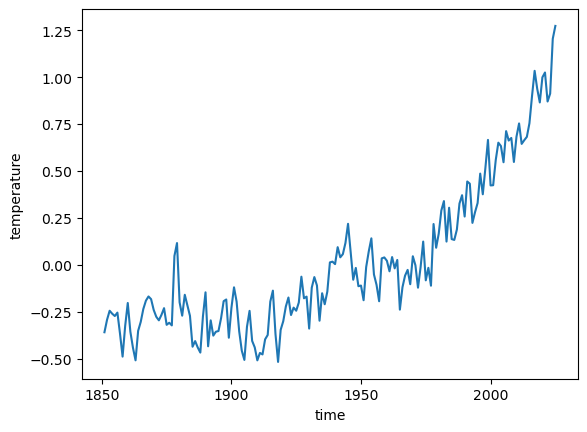

In [10]:
best_ds_smean.plot()

In [11]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [12]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

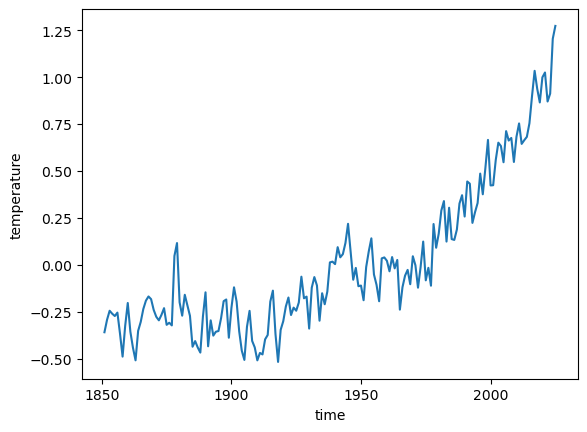

In [13]:
best_ds_smean.plot()

# Calculations

In [14]:
window = 20

## Signal-to-Noise

In [15]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=40)#method='POLYNOMIAL', order=4)#

In [16]:
noise_ds = base_period_ds.std(dim='time').to_numpy()
noise_ds

array(0.11661059)

In [17]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth - base_period_ds_average

In [18]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 175)>
-0.3279 -0.3073 -0.2862 -0.2647 -0.2428 ... 10.81 11.02 11.23 11.43 11.64
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [139]:
ds_best_sn.attrs = {'longname': 'Signal-to-Noise Ratio'}

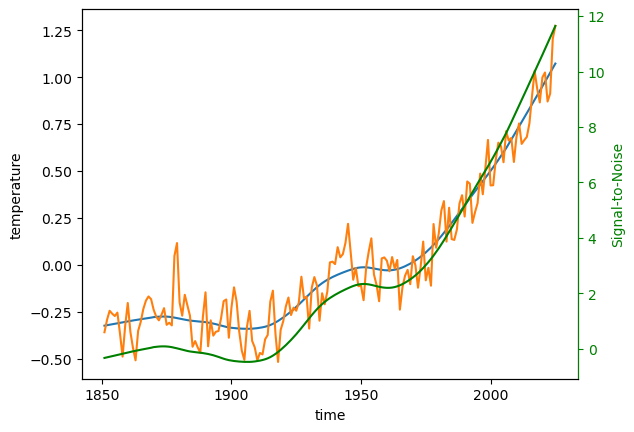

In [20]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_smooth.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

## p-value tests

In [137]:
# This version is better
ks_ds = toe.stats_test_with_ufunc(best_ds_smean, window, base_period_ds, statistic_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_with_ufunc(best_ds_smean, window, base_period_ds, statistic_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_with_ufunc(best_ds_smean, window, base_period_ds, statistic_func=toe.return_anderson_pvalue)

In [138]:
ks_ds

<xarray.DataArray (time: 156)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1869-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (1)

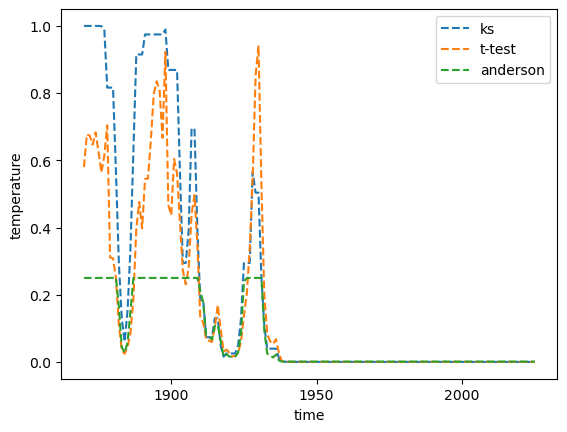

In [108]:
ks_ds.plot(label='ks', linestyle='--')
ttest_ds_2.plot(label='t-test', linestyle='--')
anderson_ds_2.plot(label='anderson', linestyle='--')

plt.legend()

# Getting ToE

In [148]:
sn_toe_val = toe.get_permanent_exceedance(ds_best_sn, threshold=2, comparison_func=np.greater)

In [149]:
ks_toe_val = toe.get_permanent_exceedance(ks_ds, threshold=0.01, comparison_func=np.less)

In [150]:
ttest_toe_val = toe.get_permanent_exceedance(ttest_ds, threshold=0.01, comparison_func=np.less)

In [151]:
anderson_toe_val = toe.get_permanent_exceedance(anderson_ds, threshold=0.01, comparison_func=np.less)

In [152]:
sn_toe_val

<xarray.DataArray 'temperature' ()>
1.94e+03

In [174]:
exceedance_dict_w_plot_coords = {
    'ks_test': create_exceedance_single_point_dict(ks_toe_val, ks_ds),
    'ttest': create_exceedance_single_point_dict(ttest_toe_val, ttest_ds),
    'anderson_darling': create_exceedance_single_point_dict(anderson_toe_val, anderson_ds),
    'sn': create_exceedance_single_point_dict(sn_toe_val, ds_best_sn),  
}
exceedance_dict_w_plot_coords

{'ks_test': {'year': array(1937.),
  'year_datetime': cftime.DatetimeGregorian(1937, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 0.0031886855178668632},
 'ttest': {'year': array(1937.),
  'year_datetime': cftime.DatetimeGregorian(1937, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 0.0020651103191060174},
 'anderson_darling': {'year': array(1936.),
  'year_datetime': cftime.DatetimeGregorian(1936, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 0.0045490597031996125},
 'sn': {'year': array(1940.),
  'year_datetime': cftime.DatetimeGregorian(1940, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 2.0012973984960367}}

# Plotting

In [160]:
def flip_pvalue(pvalue):
    return np.abs(pvalue-1)

In [175]:
TEST_COLOR_DICT = {
    'ks_test':'red',
    'ttest': 'orange',
    'anderson_darling':'sienna',
    'sn': 'blue'
}

Text(0.5, 0, 'Time')

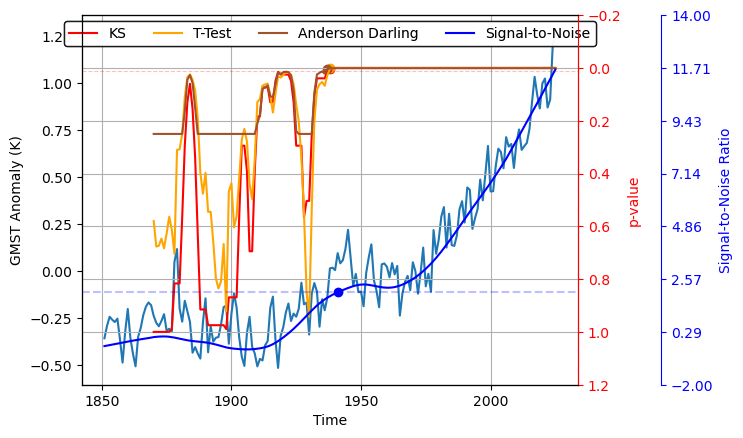

In [208]:
fig, ax_base = plt.subplots()
ax1 = ax_base.twinx() # p-value tests
ax2 = ax_base.twinx() # SN

ax1.plot(ks_ds.time.values, flip_pvalue(ks_ds.to_numpy()), c='red', label='ks')
ax1.plot(ttest_ds.time.values, flip_pvalue(ttest_ds.to_numpy()), c='orange', label='T-Test')
ax1.plot(anderson_ds.time.values, flip_pvalue(anderson_ds.to_numpy()), c='sienna', label='anderson darling')
ds_best_sn.plot(ax=ax2, c='blue')

for ax, color in zip([ax1, ax2],['red', 'blue']):
    ax.spines['right'].set_color(color)
    ax.tick_params(axis='y', color=color, labelcolor=color)


ax1.axhline(0.99, linestyle='--', color='red', alpha=0.25, linewidth=0.8)
ax2.axhline(2, linestyle='--', color='blue', alpha=0.25, linewidth=1.5)


for test_name, dobj in exceedance_dict_w_plot_coords.items():
    color = TEST_COLOR_DICT[test_name]
    if test_name == 'sn': ax=ax2; val = dobj['val']
    else: ax=ax1; val = flip_pvalue(dobj['val'])
    ax.scatter(dobj['year_datetime'], val, color=color)



ax1.set_ylim(-0.1, 1.1)

plotting_functions.match_ticks(ax1, ax2)
ax1.set_yticklabels([label.get_text() for label in ax1.get_yticklabels()][::-1])

ax1.set_ylabel('p-value', color='red')
ax2.set_ylabel('Signal-to-Noise Ratio', color='blue')

ax2.spines['right'].set_position(('outward', 60))

best_ds_smean.plot(ax=ax_base)
ax_base.set_ylabel('GMST Anomaly (K)')

ax1.grid(True)
ax_base.grid(True, axis='x')



# Define the lines and labels for the legend
legend_lines = [
    ax1.plot([], [], color='red', label='KS')[0],
    ax1.plot([], [], color='orange', label='T-Test')[0],
    ax1.plot([], [], color='sienna', label='Anderson Darling')[0],
    ax2.plot([], [], color='blue', label='Signal-to-Noise')[0]
]

# Create the legend
legend = ax_base.legend(ncol=4, handles=legend_lines, loc='center', bbox_to_anchor=(0.5, 0.95), frameon=True)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black

# Move the legend to the left side
ax_base.add_artist(legend)

ax_base.set_xlabel('Time')

In [350]:
central_year  = 1883
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-10, central_year+11)))

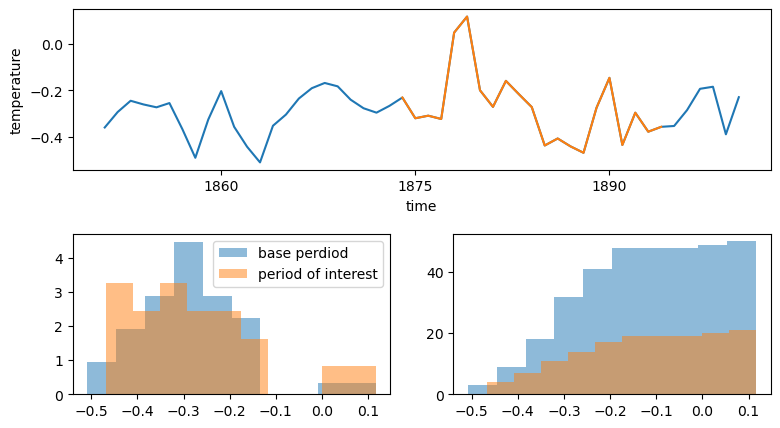

In [351]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);